In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
import torch
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import importlib 
import src.utils as utils
import json
import numpy as np
from PIL import Image

/nix/store/7aay3ymhf5c80gky4jy5fcn077msdy90-python3-3.9.11-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inverse transform sampling

In [58]:
lamb = 0.1
exp_dist = lamb*torch.exp(lamb*torch.arange(100))
exp_dist = torch.unsqueeze(exp_dist, 0)

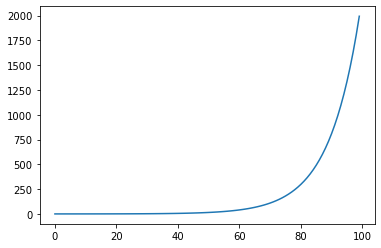

In [10]:
plt.plot(torch.arange(100), exp_dist[0]);

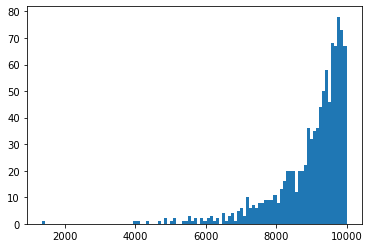

In [11]:
dist = utils.sample_fine(1000, torch.arange(101).unsqueeze(0), exp_dist).detach()
a = torch.round(dist * 100)
plt.hist(a, 100);

In [12]:
dist = Categorical(probs=exp_dist)

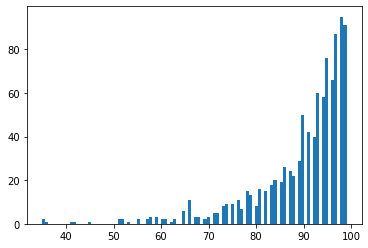

In [13]:
plt.hist(dist.sample((1000,)).numpy(), 100);

In [79]:
with open('./dataset/nerf_synthetic/chair/transforms_train.json') as f:
    data = json.load(f)
    
cm = torch.Tensor(data['frames'][0]['transform_matrix'])
w = 800
h = 800
f = (w/2)*(1/np.tan(data['camera_angle_x']/2))

In [80]:
o, d = utils.get_rays(cm, f, h, w)

In [82]:
oz = o[0,0].unsqueeze(0)
dz = d[0,0].unsqueeze(0)
a, b = utils.transform_to_ndc(oz, dz, 1, f, h, w)

tensor([[ 0.9426,  1.5231, -1.0000]])


In [88]:
o[0][0]
torch.max(d)

tensor(0.6940)

In [44]:
b[0]

tensor([-0.2208, -0.9157,  2.0000])

In [46]:
a + 0.5*b

tensor([[0.3923, 0.7681, 0.0000]])

In [15]:
from PIL import Image
import torchvision.transforms.functional as F

img = Image.open('dataset/nerf_synthetic/chair/train/r_0.png').convert('RGBA')
bkg = Image.new('RGBA', img.size, (255, 255, 255))
img = Image.alpha_composite(bkg, img).convert('RGB')
img = F.to_tensor(img)
img = img.reshape(3, -1).t()

In [3]:
B = 4
t = 7
d = 3
ts = torch.rand(B, t)
os = torch.rand(B, d)
ds = torch.rand(B, d)

In [76]:
ts[:,None,...].shape

torch.Size([4, 1, 7])

In [83]:
(ts[...,None]*ds[:,None,:]).shape

torch.Size([4, 7, 3])

In [10]:
importlib.reload(utils);
near = 3*torch.ones(B)
far = 5*torch.ones(B)
n = 5
utils.sample_coarse(B, n, near, far)

tensor([[3.2815, 3.7656, 3.8536, 4.3467, 4.8907],
        [3.3031, 3.4774, 3.9770, 4.2670, 4.9960],
        [3.0798, 3.5583, 3.8934, 4.3691, 4.7724],
        [3.1439, 3.6133, 4.1749, 4.4962, 4.7734]])

In [7]:
import src.dataset as ds
from pathlib import Path

dataset = ds.NeRFBlenderDataSet("train", Path("/home/ishaanshah/nerf/dataset/nerf_synthetic/lego/"), 0.1)

torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size([6400, 3])
torch.Size

In [6]:
dataset = ds.NeRFBlenderDataSet("train", Path("/home/ishaanshah/nerf/dataset/nerf_synthetic/lego/"), 0.1)

tensor([[[-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         ...,
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081]],

        [[-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         ...,
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081]],

        [[-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         ...,
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081]],

        ...,

        [[-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         ...,
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081],
         [-0.0538,  3.8455,  1.2081]],

        [[